In [1]:
import time
start_time=time.time()

In [2]:
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import lmfit
from scipy import interpolate
import pickle

from bfunc import bfunc00,bfunc01,bfunc02

Data load and region parameters

In [3]:
name = 'CarC'

In [4]:
reg = 'Carina'

In [5]:
pickle_in = open('SFresults//' + name + '.pkl',"rb")
SFresults = pickle.load(pickle_in)

In [6]:
B = SFresults['b2']
r = SFresults['s']
s0 = SFresults['s0']   
m = SFresults['m'] 
sig2 = SFresults['sig2'] 
r0 = SFresults['r0'] 
noise = B.mean()*0.05

In [7]:
model02 = lmfit.Model(bfunc02)
model02.param_names

['r0', 'sig2', 'm', 's0', 'noise']

In [8]:
relative_uncertainty = 0.275
weights = 1.0 / (relative_uncertainty * B)
weights[r > r0] /= 1.75

In [9]:
for p in model02.param_names:
    model02.set_param_hint(p, min=0.0)
#model02.set_param_hint("sig2", value=sig2, vary=False)
#model02.set_param_hint("s0", min=0.2)
model02.print_param_hints()

Name      Value      Min      Max     Vary    Expr    
m           nan        0      inf     True    
noise       nan        0      inf     True    
r0          nan        0      inf     True    
s0          nan        0      inf     True    
sig2        nan        0      inf     True    


In [10]:
result2 = model02.fit(
    B, 
    weights=weights,
    r = r, r0 = r0, m = m, s0 = s0, noise = noise, sig2=sig2,
)

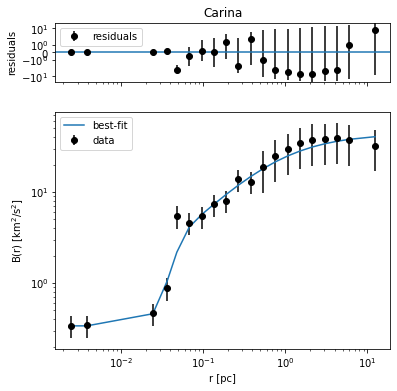

In [11]:
fig, _ = result2.plot( 'ko')
fig.axes[0].set(
    title=reg,
    xscale="log",
    yscale="symlog",
)
fig.axes[1].set(
    xscale = "log",
    yscale = "log",
    xlabel = "r [pc]",
    ylabel = r"B(r) [km$^{2}$/s$^{2}$]",
);

plt.savefig('Imgs//SF//' + reg + '.pdf', bbox_inches='tight')



In [12]:
CIresults = {'resultCI' : result2,
            'Rmax/r0' : r.max()/result2.params['r0'].value,
            'lT' : (r[3]/2**0.5)*((result2.params['r0'].value/r[3])**(result2.params['m'].value/2))
          }

In [13]:
f = open('CIresults//' + name +'.pkl',"wb")
pickle.dump(CIresults,f)
f.close()

In [14]:
print(result2.fit_report())

[[Model]]
    Model(bfunc02)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 94
    # data points      = 20
    # variables        = 5
    chi-square         = 7.10576080
    reduced chi-square = 0.47371739
    Akaike info crit   = -10.6965288
    Bayesian info crit = -5.71786740
[[Variables]]
    r0:     0.80496618 +/- 0.51205487 (63.61%) (init = 0.4808652)
    sig2:   21.6944610 +/- 5.38993801 (24.84%) (init = 17.88722)
    m:      0.92708243 +/- 0.19777053 (21.33%) (init = 1.1)
    s0:     0.02324676 +/- 0.00275844 (11.87%) (init = 0.003946445)
    noise:  0.33742419 +/- 0.04257286 (12.62%) (init = 0.8790085)
[[Correlations]] (unreported correlations are < 0.100)
    C(r0, sig2)  =  0.926
    C(r0, m)     = -0.905
    C(m, s0)     = -0.731
    C(sig2, m)   = -0.724
    C(r0, s0)    =  0.562
    C(sig2, s0)  =  0.431
    C(s0, noise) =  0.217


In [15]:
for p in result2.model.param_names:
    result2.params[p].stderr = result2.params[p].value * 0.1

In [16]:
result2.conf_interval()
print(result2.ci_report())

C:\Users\ZAINTEL2\anaconda3\lib\site-packages\lmfit\confidence.py:319: UserWarning: maxiter=200 reached and prob(r0=16.984786409826633) = 0.9690085756023132 < max(sigmas).
  warn(errmsg)
C:\Users\ZAINTEL2\anaconda3\lib\site-packages\lmfit\confidence.py:327: UserWarning: rel_change=9.977064535550768e-06 < 1e-05 at iteration 152 and prob(sig2=351.4502687524903) = 0.990574587556898 < max(sigmas).
  warn(errmsg)


          99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 r0   :  -0.61157  -0.48179  -0.30530   0.80497  +0.82763  +8.39752      +inf
 sig2 : -11.80110  -8.00839  -4.24001  21.69446  +6.13888 +24.35236      +inf
 m    :  -0.58058  -0.36172  -0.17161   0.92708  +0.17914  +0.39701  +0.72257
 s0   :  -0.00889  -0.00490  -0.00229   0.02325  +0.00245  +0.00562  +0.01072
 noise:  -0.15186  -0.09222  -0.04368   0.33742  +0.04360  +0.09180  +0.15070


In [17]:
plt.style.use([
    "seaborn-poster",
])

In [18]:
plot_limits = {
    "s0": [0.0, 0.1],
    "m": [.5, .5],
    "r0": [0.1, 1.0],
    "noise": [0.0, 0.5],
}

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

plt.title('M8')
levels = [0.6827, 0.9545, 0.9973]
colors = ["g", "y", "r"]

for ax, [xvar, yvar] in zip(axes.flat, [
    ["s0", "noise"],
    ["r0", "m"],
    ["m", "s0"],
    ["r0", "s0"],
]):
    cx, cy, grid = lmfit.conf_interval2d(
        result2, result2, xvar, yvar, 30, 30,
        limits=[plot_limits[xvar], plot_limits[yvar]],
    )
    ctp = ax.contour(cx, cy, grid, levels, colors=colors)
    ax.set_xlabel(xvar)
    ax.set_ylabel(yvar)

fig.tight_layout();

In [19]:
print("--- %s seconds ---" % (time.time()-start_time))

--- 90.94537591934204 seconds ---
